# Neural Network

## Load Data

In [2]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [00:39, 4.35MB/s]                              



Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


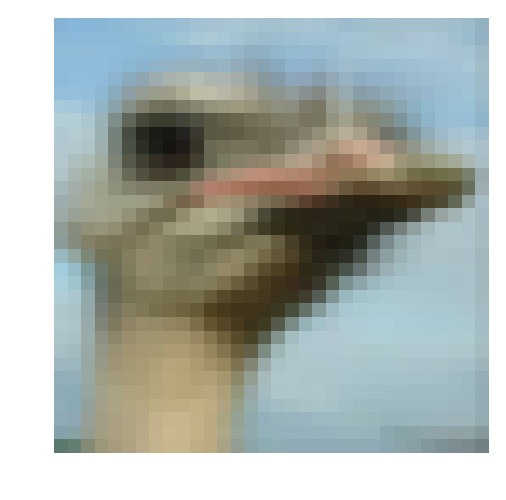

In [3]:
# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess Data

In [4]:
def normalize(x):
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)

def one_hot_encode(x):
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [3]:
import pickle
import helper

# Load the Preprocessed Validation data for cifar-10
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [4]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [7]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [98]:
class Network(object):
    
    def __init__(self, x_dim, n_classes, p_l1_w, p_l2_w):
        # Inputs
        self.p_l1_w = p_l1_w
        self.p_l2_w = p_l2_w
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_classes], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.Variable(self.p_l1_w, dtype=tf.float32, name='l1_w')
        self.l2_w = tf.Variable(self.p_l2_w, dtype=tf.float32, name='l2_w')

    def build(self):
        l1_a = tf.sigmoid(tf.matmul(self.x, self.l1_w))
        logits = tf.matmul(l1_a, self.l2_w)
        return logits

In [99]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [150]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

In [145]:
def damped_sin(x):
    y = 0
    if x <= 0:
        y = np.exp(-x)
    else:
        y = np.exp(x)
    y *= np.abs(np.cos(2*np.pi*x))
    return y

Optimize:  False
<function truncated_normal at 0x165bc2598>


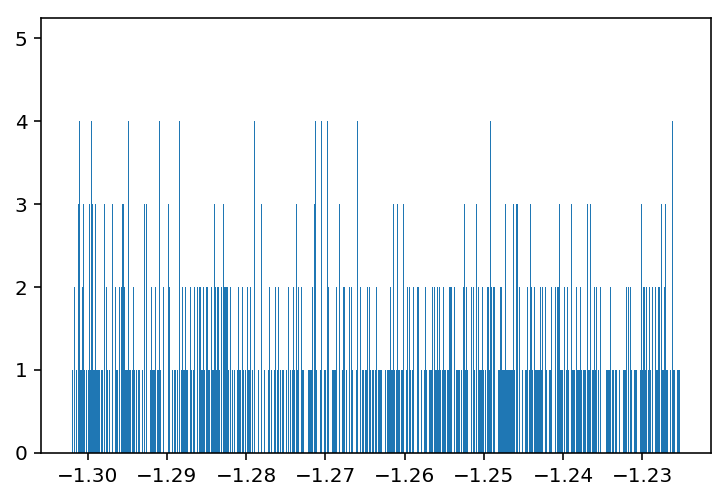

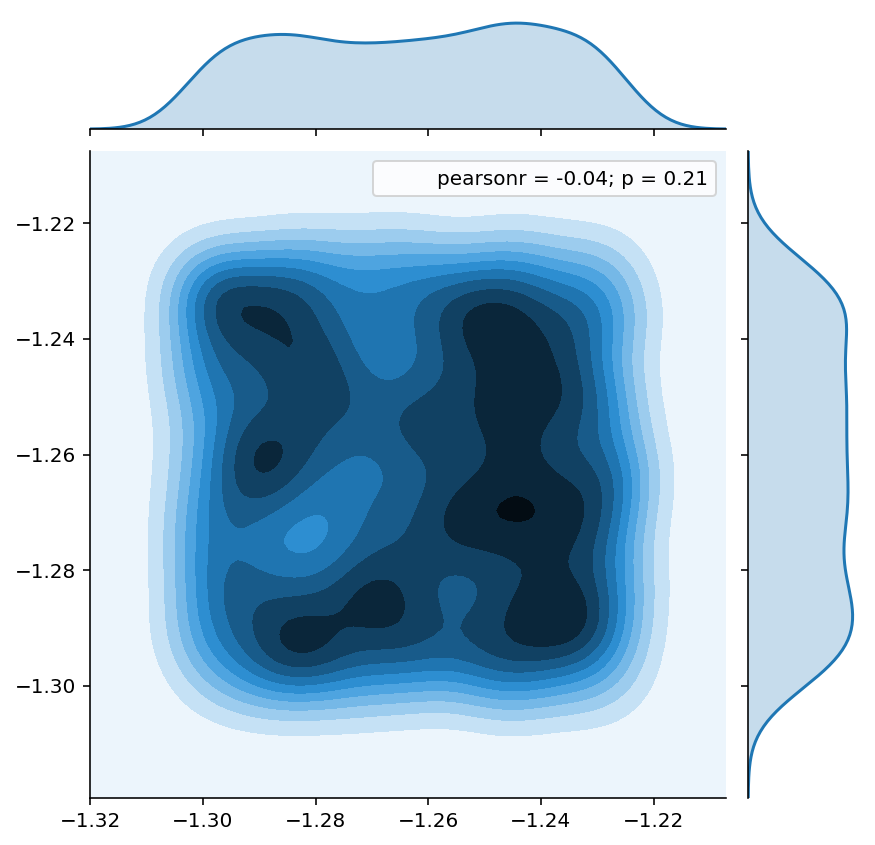

<built-in method normal of mtrand.RandomState object at 0x10e686af8>


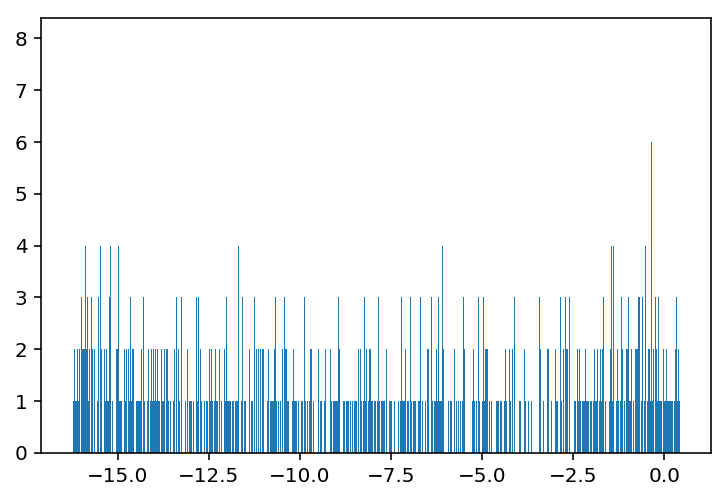

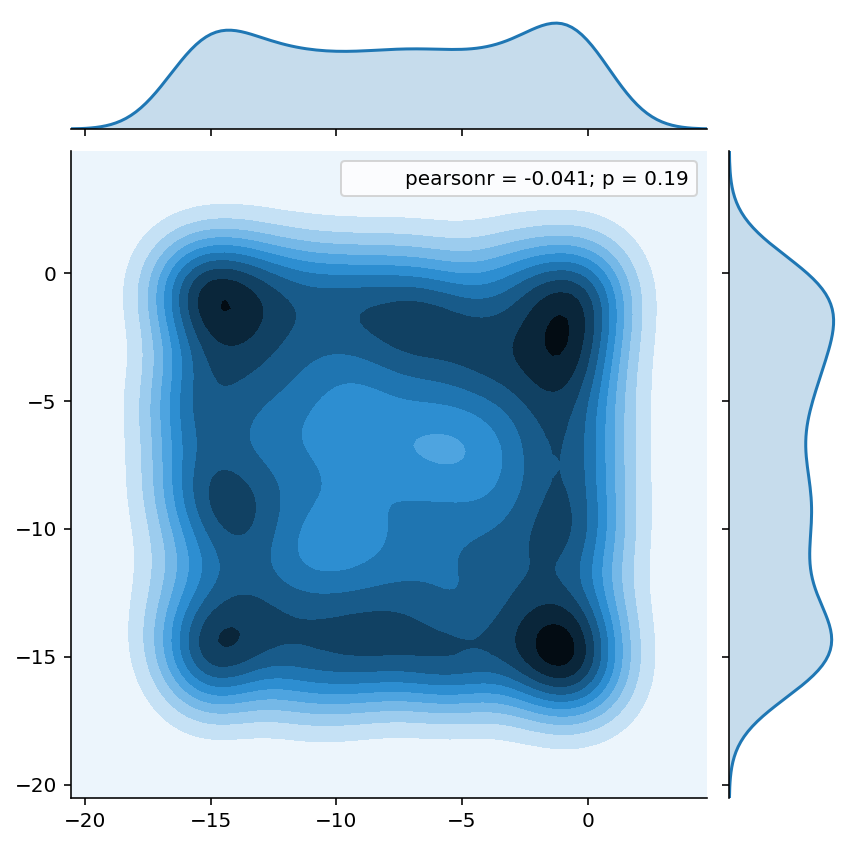

<built-in method uniform of mtrand.RandomState object at 0x10e686af8>


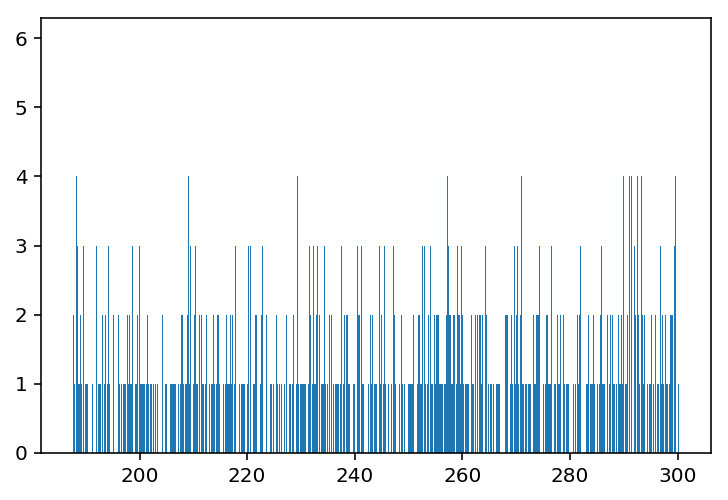

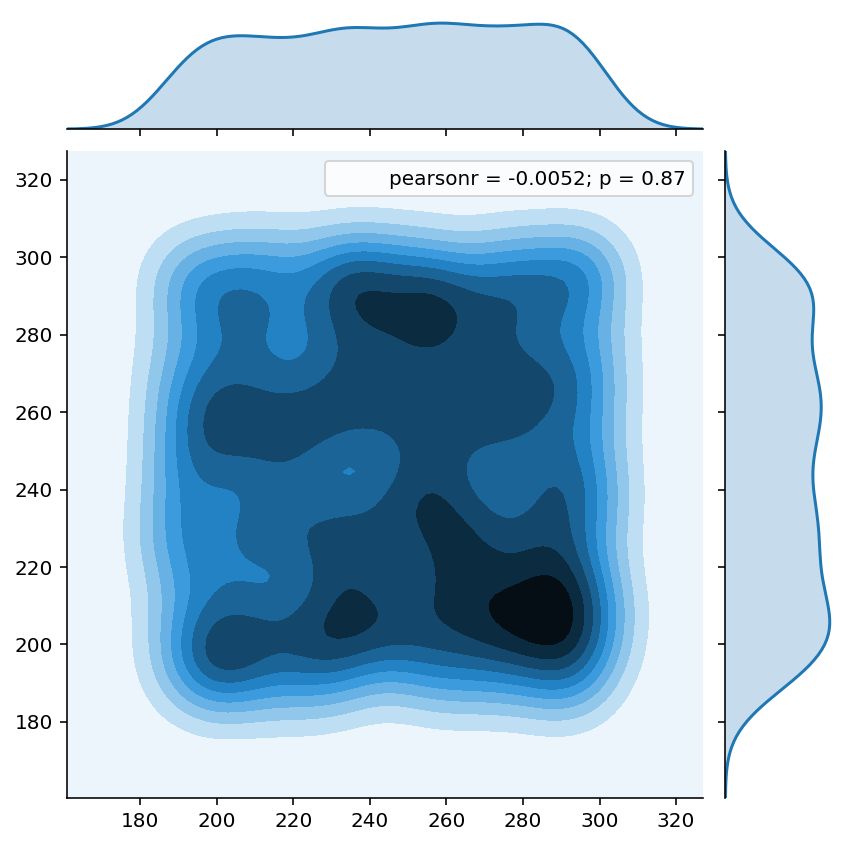

Optimize:  True
<function truncated_normal at 0x165bc2598>


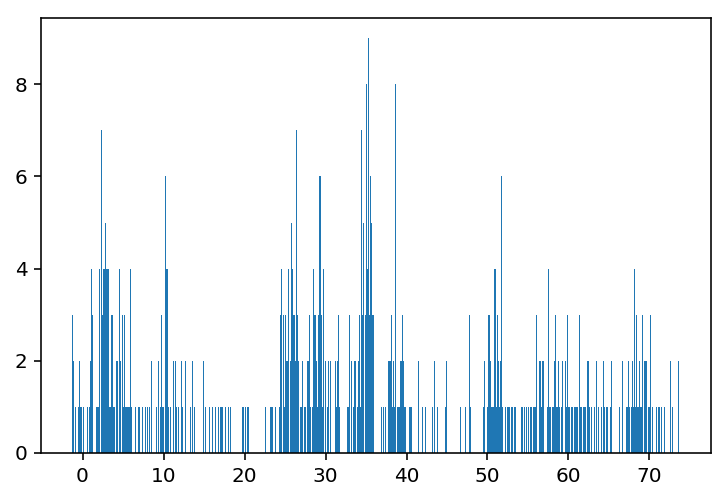

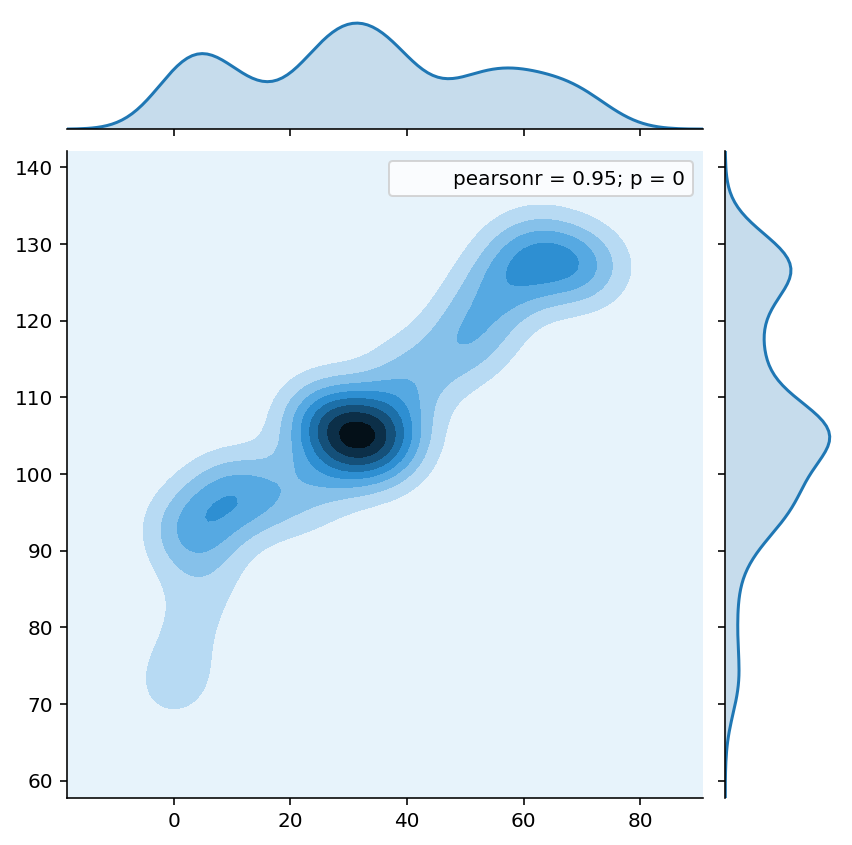

<built-in method normal of mtrand.RandomState object at 0x10e686af8>


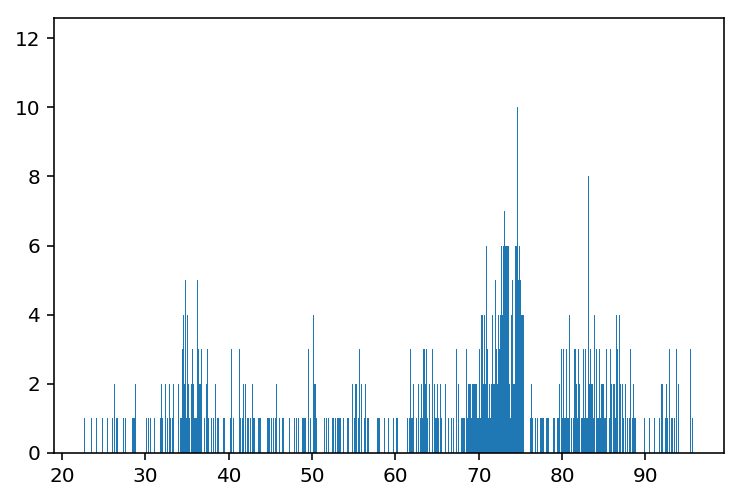

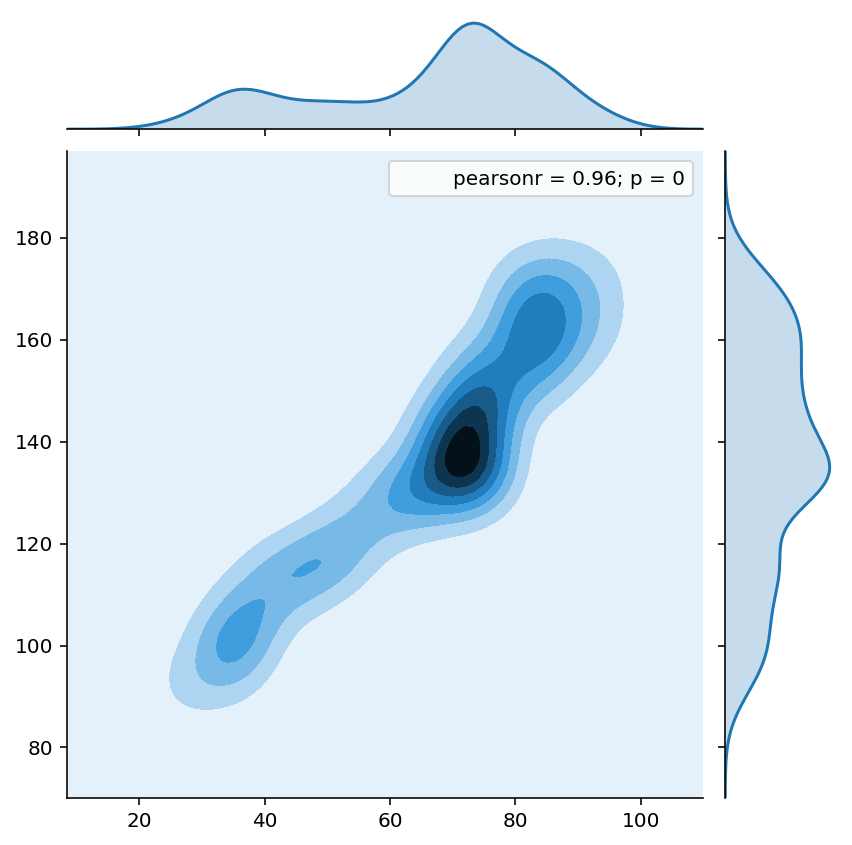

<built-in method uniform of mtrand.RandomState object at 0x10e686af8>


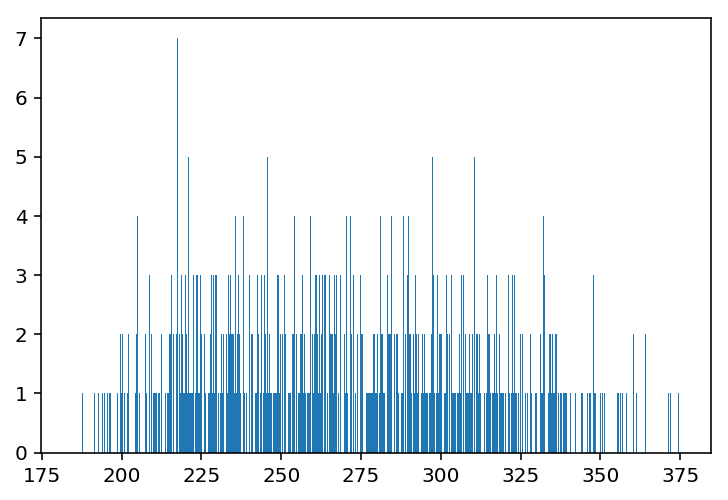

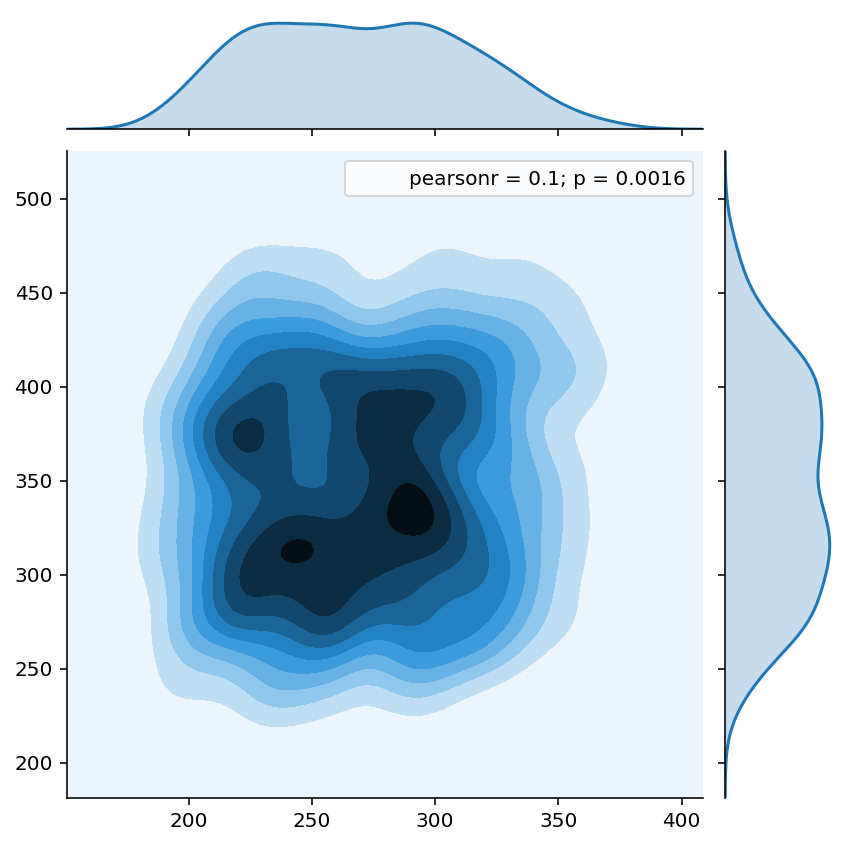

In [155]:
x_dim = 1
n_hidden = 1000
n_classes = 1
n_tests = 2
epochs = 1000

for optim in [False, True]:
    print('Optimize: ', optim)
    
    for activation_function in [truncated_normal, np.random.normal, np.random.uniform]:
        with tf.Session() as sess:

            l1_w = [[activation_function() for _ in range(n_hidden)] for _ in range(x_dim)]
            l2_w = [[activation_function() for _ in range(n_classes)] for _ in range(n_hidden)]

            net = Network(x_dim, n_classes, l1_w, l2_w)
            sess.run(tf.global_variables_initializer())

            xs = np.zeros((n_tests, epochs))
            ys = np.zeros((n_tests, epochs))

            # Initializing the variables
            for t in range(n_tests):
                for e in range(epochs):
                    x = np.random.uniform(low=-1, high=1)
                    y = damped_sin(x)
                    feed_dict = {
                        net.x: [[x]],
                        net.y: [[y]]
                    }
                    logits_ = sess.run([net.logits, net.prediction], feed_dict=feed_dict)
                    xs[t, e] = x
                    ys[t, e] = logits_[0]
                    if optim:
                        _ = sess.run([net.optimizer], feed_dict=feed_dict)

        print(str(activation_function))
        plt.hist(ys[0], bins=epochs)
        plt.show()

        sns.jointplot(x=ys[0], y=ys[1], kind='kde')
        plt.show()